In [153]:
import numpy as np
import matplotlib.pyplot as plt
from jupyterthemes import jtplot
import set_neutral_position
import ndiff
import pandas as pd
from imp import reload
jtplot.style()
%matplotlib inline

ppm_routines = ndiff.ppm_routines

In [289]:
# Some simple functions to set up the and perform the neutral diffusion flux calculations
def ppm_reconstruction(h, Slayer):    
    Sinterface = np.zeros(np.size(Slayer)+1, dtype=np.float32)
    ppm_routines.interface_scalar(h, Slayer, Sinterface, 2)
    Sl = np.zeros(np.size(Slayer), dtype=np.float32)
    Sr = np.zeros(np.size(Slayer), dtype=np.float32)
    ppm_routines.ppm_left_right_edge_values(Slayer.astype(np.float32), Sinterface, Sl, Sr)
    return Sl, Sr

def construct_column(h, T):
    zi = np.array(0) ; zi = np.append(zi,hl.cumsum())
    z_t = h.cumsum() - h[0]
    z_b = h.cumsum()
    z_c = h.cumsum() - 0.5*h
    T_t, T_b = ppm_reconstruction(h,T)
    
    return zi, z_t, z_b, z_c, T_t, T_b

def interp_reconstruction(T_t, T_c, T_b, P, k):
    if P == 0.:
        return T_t[k]
    if P == 1.:
        return T_b[k]
    elif P>0. and P<1.:
        T_int = np.interp( P, np.array( (0., 0.5, 1.) ), np.array( (T_t[k], T_c[k], T_b[k]) ) )
        return T_int
    else:
        print(k, P)

def plot_neutral_surfaces(zr_t, zr_c, zr_b, Tr_t, Tr, Tr_b, PoR_abs, KoR,
                          zl_t, zl_c, zl_b, Tl_t, Tl, Tl_b, PoL_abs, KoL, search_dir):
    # Plot PPM reconstructon of left column
    for k in np.arange(0,hl.size):
        z = np.array( [zl_t[k], zl_c[k], zl_b[k]])
        T = np.array( [Tl_t[k], Tl[k], Tl_b[k]] )
        plt.plot(T,z, color='green')
        plt.scatter(Tl_t, zl_t, marker='^')
        plt.scatter(Tl_b, zl_b, marker='v')
    # PPM reconstruction of right column 
    for k in np.arange(0,hl.size):
        z = np.array( [zr_t[k], zr_c[k], zr_b[k]] )
        T = np.array( [Tr_t[k], Tr[k], Tr_b[k]] )
        plt.plot(T,z, color = 'cyan')
        plt.scatter(Tr_t, zr_t, marker='^')
        plt.scatter(Tr_b, zr_b, marker='v')    
    
    # Plot neutral surfaces
    for k in np.arange(0,PoR_abs.size):
        kr = KoR[k]
        Tr_int = interp_reconstruction(Tr_t, Tr, Tr_b, PoR[k], kr)
        kl = KoL[k]
        Tl_int = interp_reconstruction(Tl_t, Tl, Tl_b, PoL[k], kl)
        if search_dir[k] == 0:
            #plt.plot(np.array( (Tl_int, Tr_int) ), np.array( (PoL_abs[k],PoR_abs[k]) ) , ':', color="green" ) 
            plt.arrow( Tl_int, PoL_abs[k], Tr_int - Tl_int , PoR_abs[k] - PoL_abs[k], head_width=0.5, color="green" ) 
        else:
            plt.arrow( Tr_int, PoR_abs[k], Tl_int - Tr_int , PoL_abs[k] - PoR_abs[k], head_width=0.5, color="cyan" )
            #plt.plot(np.array( (Tl_int, Tr_int) ), np.array( (PoL_abs[k],PoR_abs[k]) ) , ':', color="cyan" ) 
        print("Surface %d:" % k, Tl_int, Tr_int, PoL_abs[k], PoR_abs[k])
    plt.xlim( (5,22.5) )
    plt.grid(ls='dotted')
    plt.xlabel('Temperature')
    plt.gca().invert_yaxis()    
        

# Overview
This notebook and accompanying code mimics how MOM6 finds the neutral surfaces along which to perform parameterized diffusion. The examples in here are based on Alistair Adcrofts schematics where density is controlled by temperature with $\frac{d\rho}{dT} = -1$. Unlike his original slides, in this notebook, a discontinuous reconstruction of temperature is done

In [290]:
# Set up some examples based on Alistair's schematics of
nk = 4
Sl_t = np.zeros(nk) ; Sl_b = np.zeros(nk)
Sr_t = np.zeros(nk) ; Sr_b = np.zeros(nk)
drdt_lt = -1*np.ones(nk) ; drdt_lb = -1*np.ones(nk)
drds_lt = np.zeros(nk) ; drds_lb = np.zeros(nk)
drdt_rt = -1*np.ones(nk) ; drdt_rb = -1*np.ones(nk)
drds_rt = np.zeros(nk) ; drds_rb = np.zeros(nk)

# Identical columns

In [371]:
# Warmer on right
reload(set_neutral_position)
hl = np.array([10.,10.,10.,10.])
hr = np.array([10.,10.,10.,10.])
Tr = np.array([20.,16.,12.,10.])
Tl = np.array([20.,16.,12.,10.])
zil, zl_t, zl_b, zl_c, Tl_t, Tl_b = construct_column(hl, Tl)
zir, zr_t, zr_b, zr_c, Tr_t, Tr_b = construct_column(hr, Tr)
PoL, PoR, PoL_abs, PoR_abs, KoL, KoR, hEff, hL, hR, search_dir = set_neutral_position.set_neutral_surface_position2(
    zil, Tl_t, Tl_b, Sl_t, Sl_b, drdt_lt, drdt_lb, drds_lt, drds_lb,
    zir, Tr_t, Tr_b, Sr_t, Sr_b, drdt_rt, drdt_rb, drds_rt, drds_rb)
df_identical = pd.DataFrame({'PoL': PoL, 'PoR': PoR, 'zl': PoL_abs, 'zr': PoR_abs, 'KoL': (KoL+1), 'KoR': (KoR+1), 'hL': hL, 'hR': hR})
print(hEff.sum())


Working on k_surface 0: Tl[0,0]: 20.000000 Tr[0,0]: 20.000000
Searching from right layer 0 Interface 0
Searching in left layer 0: dRhoTop: 0.000000 dRhoBot: 0.000000
At top or dRhoTop>0
Search bottom of same layer 0
Position on left layer 0: 0.000000
Position on right layer 0: 0.000000

Working on k_surface 1: Tl[0,0]: 20.000000 Tr[0,1]: 20.000000
Searching from left layer 0 interface 0
Searching in right layer 0: dRhoTop: 0.000000 dRhoBot: 0.000000
Layer perfectly unstratified, different search direction
Search bottom of same layer 0
Position on left layer 0: 0.000000
Position on right layer 0: 0.000000
hL: 0.000000 hR: 0.000000 hEff: 0.000000

Working on k_surface 2: Tl[0,1]: 20.000000 Tr[0,1]: 20.000000
Searching from right layer 0 Interface 1
Searching in left layer 0: dRhoTop: 0.000000 dRhoBot: 0.000000
Layer perfectly unstratified, different search direction
Search top of next layer 1
Position on left layer 0: 1.000000
Position on right layer 0: 1.000000
hL: 10.000000 hR: 10.000

40.0
    KoL  KoR  PoL  PoR    hL    hR    zl    zr
0     1    1  0.0  0.0   0.0   0.0   0.0   0.0
1     1    1  0.0  0.0   0.0   0.0   0.0   0.0
2     1    1  1.0  1.0  10.0  10.0  10.0  10.0
3     1    1  1.0  1.0   0.0   0.0  10.0  10.0
4     2    2  0.0  0.0   0.0   0.0  10.0  10.0
5     2    2  0.0  0.0   0.0   0.0  10.0  10.0
6     2    2  1.0  1.0  10.0  10.0  20.0  20.0
7     2    2  1.0  1.0   0.0   0.0  20.0  20.0
8     2    3  1.0  0.0   0.0   0.0  20.0  20.0
9     3    3  0.0  0.0   0.0   0.0  20.0  20.0
10    3    3  1.0  1.0  10.0  10.0  30.0  30.0
11    3    3  1.0  1.0   0.0   0.0  30.0  30.0
12    4    4  0.0  0.0   0.0   0.0  30.0  30.0
13    4    4  0.0  0.0   0.0   0.0  30.0  30.0
14    4    4  1.0  1.0  10.0  10.0  40.0  40.0
15    4    4  1.0  1.0   0.0   0.0  40.0  40.0
Surface 0: 18.0 20.0 0.0 0.0
Surface 1: 18.0 20.0 0.0 0.0
Surface 2: 18.0 20.0 10.0 10.0
Surface 3: 18.0 20.0 10.0 10.0
Surface 4: 16.6667 18.6667 10.0 10.0
Surface 5: 16.6667 18.6667 10.0 10.0
Su

/local/home/miniconda3/lib/python3.6/site-packages/matplotlib/figure.py:1743: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


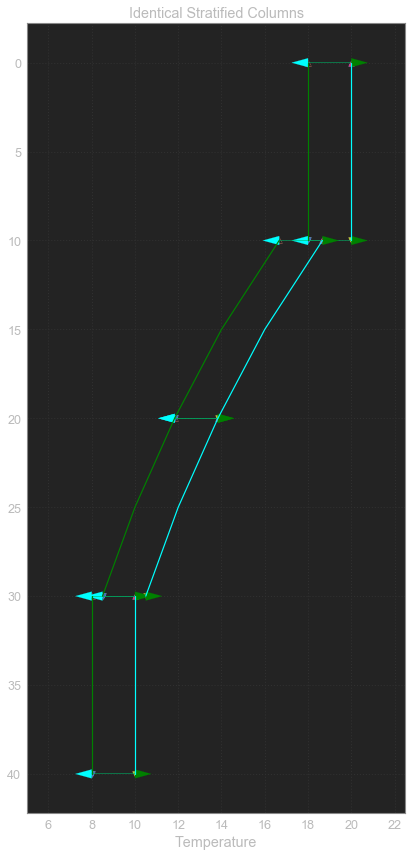

In [372]:
print(hEff.sum())
print(df_identical)
plt.figure(figsize=(6,12))
plot_neutral_surfaces(zr_t, zr_c, zr_b, Tr_t, Tr, Tr_b, PoR_abs, KoR,
                      zl_t, zl_c, zl_b, Tl_t-2, Tl-2, Tl_b-2, PoL_abs, KoL, search_dir)
plt.title('Identical Stratified Columns')

In [357]:
reload(set_neutral_position)
hl = np.array([10.,10.,10.,10.])
hr = np.array([10.,10.,10.,10.])
Pl = np.append(0.,hl.cumsum())
Pr = np.append(0.,hr.cumsum())
Tr = np.array([20.,20.,16.,12.,10.]) ; Sr = np.zeros_like(Tr)
Tl = np.array([20.,20.,16.,12.,10.]) ; Sl = np.zeros_like(Tl)
dRdTl = np.ones_like(Tl)*-1. ; dRdTr = np.ones_like(Tr)*-1. 
dRdSl = np.zeros_like(Tl) ; dRdSr = np.zeros_like(Tr)

PoL, PoR, PoL_abs, PoR_abs, KoL, KoR, hEff, hL, hR = \
    set_neutral_position.find_neutral_surface_positions_continuous(Pl, Tl, Sl, dRdTl, dRdSl, \
    Pr, Tr, Sr, dRdTr, dRdSr)
df_identical = pd.DataFrame({'PoL': PoL, 'PoR': PoR, 'zl': PoL_abs, 'zr': PoR_abs, 'KoL': (KoL+1), 'KoR': (KoR+1), 'hL': hL, 'hR': hR})
print(df_identical)


Working on k_surface 0: Tl[0]: 20.000000 Tr[0]: 20.000000
Searching left interfaces (0, 1): dRhoTop: 0.000000 dRhoBot: 0.000000
At surface or left surface is lighter than layer krm1

Working on k_surface 1: Tl[0]: 20.000000 Tr[1]: 20.000000
Searching right interfaces (0, 1): dRhoTop: 0.000000 dRhoBot: 0.000000
At surface or left surface is lighter than layer krm1

Working on k_surface 2: Tl[1]: 20.000000 Tr[1]: 20.000000
Searching left interfaces (0, 1): dRhoTop: 0.000000 dRhoBot: 0.000000
dRhoTop>=dRhoBot
Point to bottom of cell

Working on k_surface 3: Tl[1]: 20.000000 Tr[2]: 16.000000
Searching right interfaces (1, 2): dRhoTop: 0.000000 dRhoBot: 4.000000
At surface or left surface is lighter than layer krm1

Working on k_surface 4: Tl[2]: 16.000000 Tr[2]: 16.000000
Searching left interfaces (1, 2): dRhoTop: -4.000000 dRhoBot: 0.000000
Interpolating for position
Point to bottom of cell

Working on k_surface 5: Tl[2]: 16.000000 Tr[3]: 12.000000
Searching right interfaces (2, 3): dRho

# Right column is slightly warmer


Working on k_surface 0: Tl[0,0]: 18.000000 Tr[0,0]: 20.000000
Searching from right layer 0 Interface 0
Searching in left layer 0: dRhoTop: 2.000000 dRhoBot: 2.000000
At top or dRhoTop>0
Search bottom of same layer 0
Position on left layer 0: 0.000000
Position on right layer 0: 0.000000

Working on k_surface 1: Tl[0,0]: 18.000000 Tr[0,1]: 20.000000
Searching from right layer 0 Interface 1
Searching in left layer 0: dRhoTop: 2.000000 dRhoBot: 2.000000
At top or dRhoTop>0
Search top of next layer 1
Position on left layer 0: 0.000000
Position on right layer 0: 1.000000
hL: 0.000000 hR: 10.000000 hEff: 0.000000

Working on k_surface 2: Tl[0,0]: 18.000000 Tr[1,0]: 18.666666
Searching from right layer 1 Interface 0
Searching in left layer 0: dRhoTop: 0.666666 dRhoBot: 0.666666
At top or dRhoTop>0
Search bottom of same layer 1
Position on left layer 0: 0.000000
Position on right layer 1: 0.000000
hL: 0.000000 hR: 0.000000 hEff: 0.000000

Working on k_surface 3: Tl[0,0]: 18.000000 Tr[1,1]: 13.

/local/home/miniconda3/lib/python3.6/site-packages/matplotlib/figure.py:1743: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


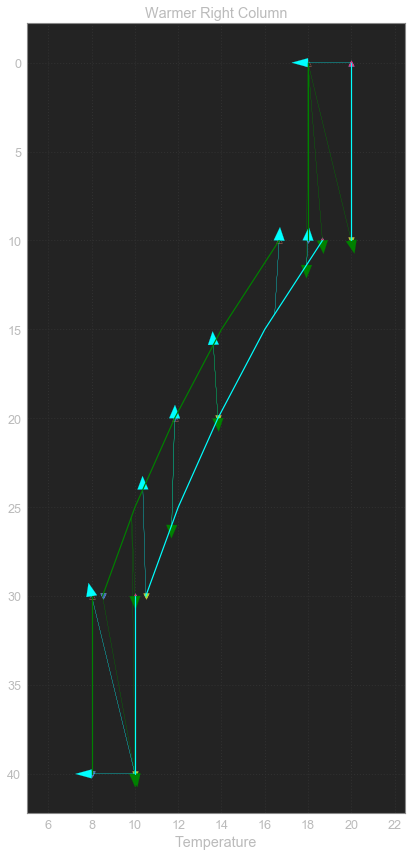

In [373]:
# Warmer on right
reload(set_neutral_position)
hl = np.array([10.,10.,10.,10.])
hr = np.array([10.,10.,10.,10.])
Tr = np.array([20.,16.,12.,10.])
Tl = np.array([18.,14.,10.,8.])
zil, zl_t, zl_b, zl_c, Tl_t, Tl_b = construct_column(hl, Tl)
zir, zr_t, zr_b, zr_c, Tr_t, Tr_b = construct_column(hr, Tr)
PoL, PoR, PoL_abs, PoR_abs, KoL, KoR, hEff, hL, hR, search_dir = set_neutral_position.set_neutral_surface_position2(
    zil, Tl_t, Tl_b, Sl_t, Sl_b, drdt_lt, drdt_lb, drds_lt, drds_lb,
    zir, Tr_t, Tr_b, Sr_t, Sr_b, drdt_rt, drdt_rb, drds_rt, drds_rb)
df_warm_right = pd.DataFrame({'PoL': PoL, 'PoR': PoR, 'zl': PoL_abs, 'zr': PoR_abs, 'KoL': (KoL+1), 'KoR': (KoR+1), 'hL': hL, 'hR': hR})
plt.figure(figsize=(6,12))
plot_neutral_surfaces(zr_t, zr_c, zr_b, Tr_t, Tr, Tr_b, PoR_abs, KoR,
                      zl_t, zl_c, zl_b, Tl_t, Tl, Tl_b, PoL_abs, KoL, search_dir)
plt.title('Warmer Right Column')
print(hEff.sum())
print(df_warm_right)

In [339]:
reload(ndiff)
Sl_t = np.zeros(hl.size) ; Sl_b = np.zeros(hl.size)
Sr_t = np.zeros(hl.size) ; Sr_b = np.zeros(hl.size)
drdt_lt = -1*np.ones(hl.size) ; drdt_lb = -1*np.ones(hl.size)
drds_lt = np.zeros(hl.size) ; drds_lb = np.zeros(hl.size)
drdt_rt = -1*np.ones(hl.size) ; drdt_rb = -1*np.ones(hl.size)
drds_rt = np.zeros(hl.size) ; drds_rb = np.zeros(hl.size)
PoL = np.zeros(4*hl.size, dtype=np.float32) ; PoR = np.zeros(4*hl.size, dtype=np.float32)
KoL = np.zeros(4*hl.size, dtype=np.int32) ; KoR = np.zeros(4*hl.size, dtype=np.int32)
hEff = np.zeros(4*hl.size - 1, dtype=np.float32)

ndiff.ppm_routines.find_neutral_surface_positions_discontinuous(
    zil, Tl_t, Tl_b, Sl_t, Sl_b, drdt_lt, drdt_lb, drds_lt, drds_lb,
    zir, Tr_t, Tr_b, Sr_t, Sr_b, drdt_rt, drdt_rb, drds_rt, drds_rb,
    PoL, PoR, KoL, KoR, hEff)

# Left Column is warmer


Working on k_surface 0: Tl[0,0]: 20.000000 Tr[0,0]: 18.000000
Searching from left layer 0 interface 0
Searching in right layer 0: dRhoTop: 2.000000 dRhoBot: 2.000000
At top or dRhoTop>0
Search bottom of same layer 0
Position on left layer 0: 0.000000
Position on right layer 0: 0.000000

Working on k_surface 1: Tl[0,1]: 20.000000 Tr[0,0]: 18.000000
Searching from left layer 0 interface 1
Searching in right layer 0: dRhoTop: 2.000000 dRhoBot: 2.000000
At top or dRhoTop>0
Search top of next layer 1
Position on left layer 0: 1.000000
Position on right layer 0: 0.000000
hL: 10.000000 hR: 0.000000 hEff: 0.000000

Working on k_surface 2: Tl[1,0]: 18.666666 Tr[0,0]: 18.000000
Searching from left layer 1 interface 0
Searching in right layer 0: dRhoTop: 0.666666 dRhoBot: 0.666666
At top or dRhoTop>0
Search bottom of same layer 1
Position on left layer 1: 0.000000
Position on right layer 0: 0.000000
hL: 0.000000 hR: 0.000000 hEff: 0.000000

Working on k_surface 3: Tl[1,1]: 13.833333 Tr[0,0]: 18.

/local/home/miniconda3/lib/python3.6/site-packages/matplotlib/figure.py:1743: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


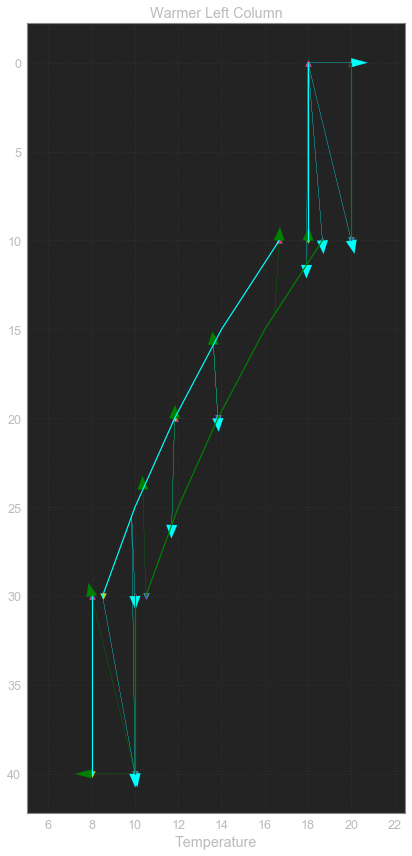

In [374]:
reload(set_neutral_position)
# Warmer on right
hl = np.array([10.,10.,10.,10.])
hr = np.array([10.,10.,10.,10.])
Tr = np.array([18.,14.,10.,8.])
Tl = np.array([20.,16.,12.,10.])
zil, zl_t, zl_b, zl_c, Tl_t, Tl_b = construct_column(hl, Tl)
zir, zr_t, zr_b, zr_c, Tr_t, Tr_b = construct_column(hr, Tr)
PoL, PoR, PoL_abs, PoR_abs, KoL, KoR, hEff, hL, hR, search_dir = set_neutral_position.set_neutral_surface_position2(
    zil, Tl_t, Tl_b, Sl_t, Sl_b, drdt_lt, drdt_lb, drds_lt, drds_lb,
    zir, Tr_t, Tr_b, Sr_t, Sr_b, drdt_rt, drdt_rb, drds_rt, drds_rb)
df_warm_left = pd.DataFrame({'PoL': PoL, 'PoR': PoR, 'zl': PoL_abs, 'zr': PoR_abs, 'KoL': (KoL+1), 'KoR': (KoR+1), 'hL': hL, 'hR': hR})
plt.figure(figsize=(6,12))
plot_neutral_surfaces(zr_t, zr_c, zr_b, Tr_t, Tr, Tr_b, PoR_abs, KoR,
                      zl_t, zl_c, zl_b, Tl_t, Tl, Tl_b, PoL_abs, KoL, search_dir)
plt.title('Warmer Left Column')
print(hEff.sum())

# Much Cooler on right


Working on k_surface 0: Tl[0,0]: 20.000000 Tr[0,0]: 8.000000
Searching from left layer 0 interface 0
Searching in right layer 0: dRhoTop: 12.000000 dRhoBot: 12.000000
At top or dRhoTop>0
Search bottom of same layer 0
Position on left layer 0: 0.000000
Position on right layer 0: 0.000000

Working on k_surface 1: Tl[0,1]: 20.000000 Tr[0,0]: 8.000000
Searching from left layer 0 interface 1
Searching in right layer 0: dRhoTop: 12.000000 dRhoBot: 12.000000
At top or dRhoTop>0
Search top of next layer 1
Position on left layer 0: 1.000000
Position on right layer 0: 0.000000
hL: 10.000000 hR: 0.000000 hEff: 0.000000

Working on k_surface 2: Tl[1,0]: 18.666666 Tr[0,0]: 8.000000
Searching from left layer 1 interface 0
Searching in right layer 0: dRhoTop: 10.666666 dRhoBot: 10.666666
At top or dRhoTop>0
Search bottom of same layer 1
Position on left layer 1: 0.000000
Position on right layer 0: 0.000000
hL: 0.000000 hR: 0.000000 hEff: 0.000000

Working on k_surface 3: Tl[1,1]: 14.000000 Tr[0,0]: 

/local/home/miniconda3/lib/python3.6/site-packages/matplotlib/figure.py:1743: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


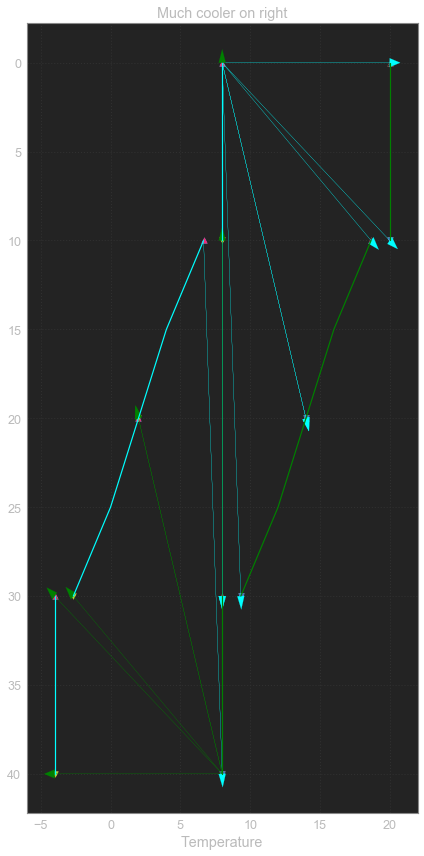

In [347]:
reload(set_neutral_position)
hl = np.array([10.,10.,10.,10.])
hr = np.array([10.,10.,10.,10.])
Tr = np.array([8., 4., 0., -4.])
Tl = np.array([20., 16., 12.,8.])
Sl_t = np.zeros(hl.size) ; Sl_b = np.zeros(hl.size)
Sr_t = np.zeros(hl.size) ; Sr_b = np.zeros(hl.size)
drdt_lt = -1*np.ones(hl.size) ; drdt_lb = -1*np.ones(hl.size)
drds_lt = np.zeros(hl.size) ; drds_lb = np.zeros(hl.size)
drdt_rt = -1*np.ones(hl.size) ; drdt_rb = -1*np.ones(hl.size)
drds_rt = np.zeros(hl.size) ; drds_rb = np.zeros(hl.size)
zil, zl_t, zl_b, zl_c, Tl_t, Tl_b = construct_column(hl, Tl)
zir, zr_t, zr_b, zr_c, Tr_t, Tr_b = construct_column(hr, Tr)
PoL, PoR, PoL_abs, PoR_abs, KoL, KoR, hEff, hL, hR, search_dir = set_neutral_position.set_neutral_surface_position2(
    zil, Tl_t, Tl_b, Sl_t, Sl_b, drdt_lt, drdt_lb, drds_lt, drds_lb,
    zir, Tr_t, Tr_b, Sr_t, Sr_b, drdt_rt, drdt_rb, drds_rt, drds_rb)
df_cool_right = pd.DataFrame({'PoL': PoL, 'PoR': PoR, 'zl': PoL_abs, 'zr': PoR_abs, 'KoL': (KoL+1), 'KoR': (KoR+1), 'hL': hL, 'hR': hR})
plt.figure(figsize=(6,12))
plot_neutral_surfaces(zr_t, zr_c, zr_b, Tr_t, Tr, Tr_b, PoR_abs, KoR,
                      zl_t, zl_c, zl_b, Tl_t, Tl, Tl_b, PoL_abs, KoL, search_dir)
plt.xlim((-6,22))
plt.title('Much cooler on right')
print(hEff.sum())

In [345]:
print(df_cool_right)

    KoL  KoR  PoL  PoR    hL    hR    zl    zr
0     1    1  0.0  0.0   0.0   0.0   0.0   0.0
1     1    1  1.0  0.0  10.0   0.0  10.0   0.0
2     2    1  0.0  0.0   0.0   0.0  10.0   0.0
3     2    1  1.0  0.0  10.0   0.0  20.0   0.0
4     3    1  0.0  0.0   0.0   0.0  20.0   0.0
5     3    1  1.0  0.0  10.0   0.0  30.0   0.0
6     4    1  0.0  0.0   0.0   0.0  30.0   0.0
7     4    1  0.0  0.0   0.0   0.0  30.0   0.0
8     4    1  0.0  1.0   0.0  10.0  30.0  10.0
9     4    1  1.0  1.0  10.0   0.0  40.0  10.0
10    4    2  1.0  0.0   0.0   0.0  40.0  10.0
11    4    2  1.0  1.0   0.0  10.0  40.0  20.0
12    4    3  1.0  0.0   0.0   0.0  40.0  20.0
13    4    3  1.0  1.0   0.0  10.0  40.0  30.0
14    4    4  1.0  0.0   0.0   0.0  40.0  30.0
15    4    4  1.0  1.0   0.0  10.0  40.0  40.0


# Identical Unstratified Column


Working on k_surface 0: Tl[0,0]: 0.000000 Tr[0,0]: 0.000000
Searching from right layer 0 Interface 0
Searching in left layer 0: dRhoTop: 0.000000 dRhoBot: 0.000000
At top or dRhoTop>0
Search bottom of same layer 0
Position on left layer 0: 0.000000
Position on right layer 0: 0.000000

Working on k_surface 1: Tl[0,0]: 0.000000 Tr[0,1]: 0.000000
Searching from left layer 0 interface 0
Searching in right layer 0: dRhoTop: 0.000000 dRhoBot: 0.000000
Layer perfectly unstratified, different search direction
Search bottom of same layer 0
Position on left layer 0: 0.000000
Position on right layer 0: 0.000000
hL: 0.000000 hR: 0.000000 hEff: 0.000000

Working on k_surface 2: Tl[0,1]: 0.000000 Tr[0,1]: 0.000000
Searching from right layer 0 Interface 1
Searching in left layer 0: dRhoTop: 0.000000 dRhoBot: 0.000000
Layer perfectly unstratified, different search direction
Search top of next layer 1
Position on left layer 0: 1.000000
Position on right layer 0: 1.000000
hL: 10.000000 hR: 10.000000 hE

/local/home/miniconda3/lib/python3.6/site-packages/matplotlib/figure.py:1743: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


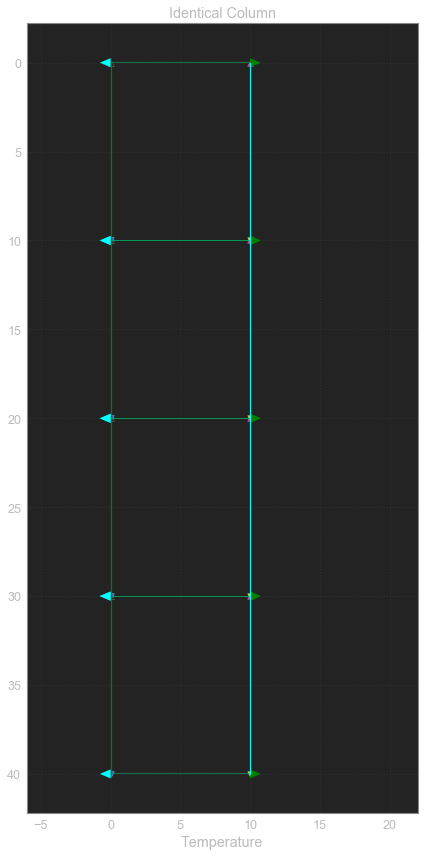

In [375]:
reload(set_neutral_position)
hl = np.array([10.,10.,10.,10.])
hr = np.array([10.,10.,10.,10.])
Tr = np.array([0., 0., 0., 0.,])
Tl = np.array([0., 0., 0., 0.,])
Sl_t = np.zeros(hl.size) ; Sl_b = np.zeros(hl.size)
Sr_t = np.zeros(hl.size) ; Sr_b = np.zeros(hl.size)
drdt_lt = -1*np.ones(hl.size) ; drdt_lb = -1*np.ones(hl.size)
drds_lt = np.zeros(hl.size) ; drds_lb = np.zeros(hl.size)
drdt_rt = -1*np.ones(hl.size) ; drdt_rb = -1*np.ones(hl.size)
drds_rt = np.zeros(hl.size) ; drds_rb = np.zeros(hl.size)
zil, zl_t, zl_b, zl_c, Tl_t, Tl_b = construct_column(hl, Tl)
zir, zr_t, zr_b, zr_c, Tr_t, Tr_b = construct_column(hr, Tr)
PoL, PoR, PoL_abs, PoR_abs, KoL, KoR, hEff, hL, hR, search_dir = set_neutral_position.set_neutral_surface_position2(
    zil, Tl_t, Tl_b, Sl_t, Sl_b, drdt_lt, drdt_lb, drds_lt, drds_lb,
    zir, Tr_t, Tr_b, Sr_t, Sr_b, drdt_rt, drdt_rb, drds_rt, drds_rb)
df_unstratified = pd.DataFrame({'PoL': PoL, 'PoR': PoR, 'zl': PoL_abs, 'zr': PoR_abs, 'KoL': (KoL+1), 'KoR': (KoR+1), 'hL': hL, 'hR': hR})
plt.figure(figsize=(6,12))
plot_neutral_surfaces(zr_t, zr_c, zr_b, Tr_t+10, Tr+10, Tr_b+10, PoR_abs, KoR,
                      zl_t, zl_c, zl_b, Tl_t, Tl, Tl_b, PoL_abs, KoL, search_dir)
plt.xlim((-6,22))
plt.title('Identical Column')
print(hEff.sum())

In [376]:
print(df_unstratified)

    KoL  KoR  PoL  PoR    hL    hR    zl    zr
0     1    1  0.0  0.0   0.0   0.0   0.0   0.0
1     1    1  0.0  0.0   0.0   0.0   0.0   0.0
2     1    1  1.0  1.0  10.0  10.0  10.0  10.0
3     1    1  1.0  1.0   0.0   0.0  10.0  10.0
4     1    2  1.0  0.0   0.0   0.0  10.0  10.0
5     2    2  0.0  0.0   0.0   0.0  10.0  10.0
6     2    2  1.0  1.0  10.0  10.0  20.0  20.0
7     2    2  1.0  1.0   0.0   0.0  20.0  20.0
8     2    3  1.0  0.0   0.0   0.0  20.0  20.0
9     3    3  0.0  0.0   0.0   0.0  20.0  20.0
10    3    3  1.0  1.0  10.0  10.0  30.0  30.0
11    3    3  1.0  1.0   0.0   0.0  30.0  30.0
12    3    4  1.0  0.0   0.0   0.0  30.0  30.0
13    4    4  0.0  0.0   0.0   0.0  30.0  30.0
14    4    4  1.0  1.0  10.0  10.0  40.0  40.0
15    4    4  1.0  1.0   0.0   0.0  40.0  40.0


# Mixed Layer on Right


Working on k_surface 0: Tl[0,0]: 14.000000 Tr[0,0]: 14.000000
Searching from right layer 0 Interface 0
Searching in left layer 0: dRhoTop: 0.000000 dRhoBot: 0.000000
At top or dRhoTop>0
Search bottom of same layer 0
Position on left layer 0: 0.000000
Position on right layer 0: 0.000000

Working on k_surface 1: Tl[0,0]: 14.000000 Tr[0,1]: 14.000000
Searching from left layer 0 interface 0
Searching in right layer 0: dRhoTop: 0.000000 dRhoBot: 0.000000
Layer perfectly unstratified, different search direction
Search bottom of same layer 0
Position on left layer 0: 0.000000
Position on right layer 0: 0.000000
hL: 0.000000 hR: 0.000000 hEff: 0.000000

Working on k_surface 2: Tl[0,1]: 14.000000 Tr[0,1]: 14.000000
Searching from right layer 0 Interface 1
Searching in left layer 0: dRhoTop: 0.000000 dRhoBot: 0.000000
Layer perfectly unstratified, different search direction
Search top of next layer 1
Position on left layer 0: 1.000000
Position on right layer 0: 1.000000
hL: 10.000000 hR: 10.000

/local/home/miniconda3/lib/python3.6/site-packages/matplotlib/figure.py:1743: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


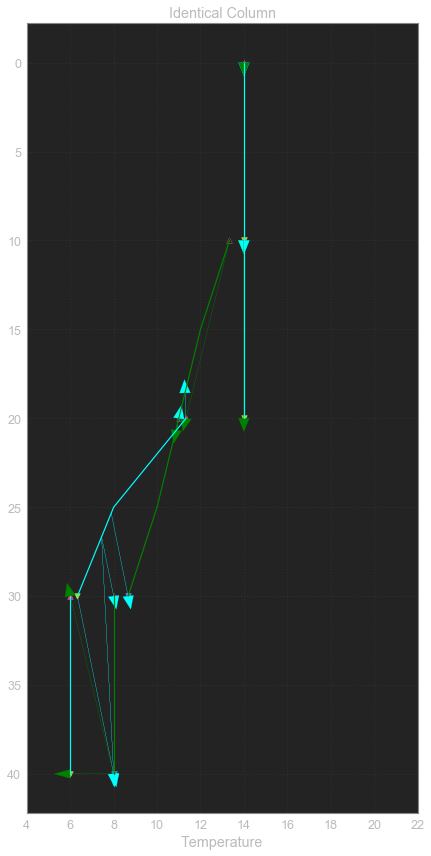

In [377]:
reload(set_neutral_position)
hl = np.array([10.,10.,10.,10.])
hr = np.array([10.,10.,10.,10.])
Tr = np.array([14., 14., 8., 6.,])
Tl = np.array([14., 12., 10., 8.,])
Sl_t = np.zeros(hl.size) ; Sl_b = np.zeros(hl.size)
Sr_t = np.zeros(hl.size) ; Sr_b = np.zeros(hl.size)
drdt_lt = -1*np.ones(hl.size) ; drdt_lb = -1*np.ones(hl.size)
drds_lt = np.zeros(hl.size) ; drds_lb = np.zeros(hl.size)
drdt_rt = -1*np.ones(hl.size) ; drdt_rb = -1*np.ones(hl.size)
drds_rt = np.zeros(hl.size) ; drds_rb = np.zeros(hl.size)
zil, zl_t, zl_b, zl_c, Tl_t, Tl_b = construct_column(hl, Tl)
zir, zr_t, zr_b, zr_c, Tr_t, Tr_b = construct_column(hr, Tr)
PoL, PoR, PoL_abs, PoR_abs, KoL, KoR, hEff, hL, hR, search_dir = set_neutral_position.set_neutral_surface_position2(
    zil, Tl_t, Tl_b, Sl_t, Sl_b, drdt_lt, drdt_lb, drds_lt, drds_lb,
    zir, Tr_t, Tr_b, Sr_t, Sr_b, drdt_rt, drdt_rb, drds_rt, drds_rb)
df_mixed_layer_right = pd.DataFrame({'PoL': PoL, 'PoR': PoR, 'zl': PoL_abs, 'zr': PoR_abs, 'KoL': (KoL+1), 'KoR': (KoR+1), 'hL': hL, 'hR': hR})
plt.figure(figsize=(6,12))
plot_neutral_surfaces(zr_t, zr_c, zr_b, Tr_t, Tr, Tr_b, PoR_abs, KoR,
                      zl_t, zl_c, zl_b, Tl_t, Tl, Tl_b, PoL_abs, KoL, search_dir)
plt.xlim((4,22))
plt.title('Identical Column')
print(hEff.sum())

In [355]:
print(df_mixed_layer_right)

    KoL  KoR       PoL       PoR        hL         hR        zl         zr
0     1    1  0.000000  0.000000   0.00000   0.000000   0.00000   0.000000
1     1    1  0.000000  0.000000   0.00000   0.000000   0.00000   0.000000
2     1    1  1.000000  1.000000  10.00000  10.000000  10.00000  10.000000
3     1    1  1.000000  1.000000   0.00000   0.000000  10.00000  10.000000
4     1    2  1.000000  0.000000   0.00000   0.000000  10.00000  10.000000
5     1    2  1.000000  1.000000   0.00000  10.000000  10.00000  20.000000
6     2    3  0.000000  0.000000   0.00000   0.000000  10.00000  20.000000
7     2    3  0.857143  0.000000   8.57143   0.000000  18.57143  20.000000
8     2    3  1.000000  0.066667   1.42857   0.666666  20.00000  20.666666
9     3    3  0.000000  0.066667   0.00000   0.000000  20.00000  20.666666
10    3    3  1.000000  0.533333  10.00000   4.666666  30.00000  25.333333
11    4    3  0.000000  0.666667   0.00000   1.333334  30.00000  26.666667
12    4    3  1.000000  0

# Right column with unstable mixed layer


Working on k_surface 0: Tl[0,0]: 12.000000 Tr[0,0]: 14.000000
Searching from right layer 0 Interface 0
Searching in left layer 0: dRhoTop: 2.000000 dRhoBot: 2.000000
At top or dRhoTop>0
Search bottom of same layer 0
Position on left layer 0: 0.000000
Position on right layer 0: 0.000000

Working on k_surface 1: Tl[0,0]: 12.000000 Tr[0,1]: 14.000000
Searching from right layer 0 Interface 1
Searching in left layer 0: dRhoTop: 2.000000 dRhoBot: 2.000000
At top or dRhoTop>0
Search top of next layer 1
Position on left layer 0: 0.000000
Position on right layer 0: 1.000000
hL: 0.000000 hR: 10.000000 hEff: 0.000000

Working on k_surface 2: Tl[0,0]: 12.000000 Tr[1,0]: 14.000000
Searching from right layer 1 Interface 0
Searching in left layer 0: dRhoTop: 2.000000 dRhoBot: 2.000000
At top or dRhoTop>0
Search bottom of same layer 1
Position on left layer 0: 0.000000
Position on right layer 1: 0.000000
hL: 0.000000 hR: 0.000000 hEff: 0.000000

Working on k_surface 3: Tl[0,0]: 12.000000 Tr[1,1]: 14.

/local/home/miniconda3/lib/python3.6/site-packages/matplotlib/figure.py:1743: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


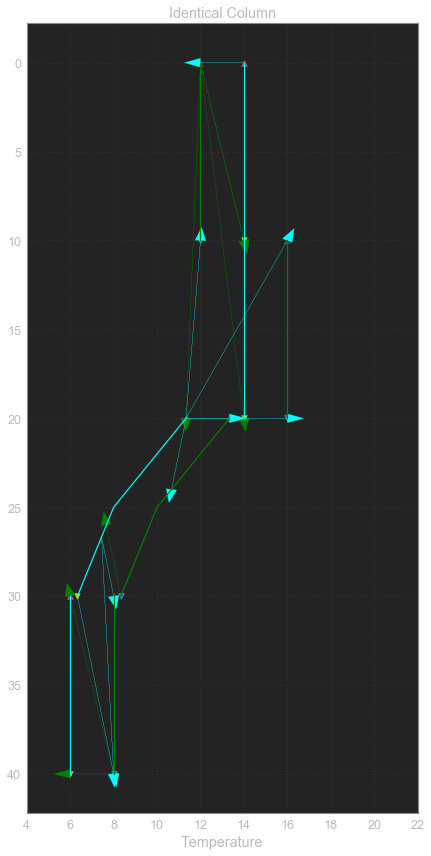

In [382]:
reload(set_neutral_position)
hl = np.array([10.,10.,10.,10.])
hr = np.array([10.,10.,10.,10.])
Tr = np.array([14., 14., 8., 6.,])
Tl = np.array([12., 16., 10., 8.,])
Sl_t = np.zeros(hl.size) ; Sl_b = np.zeros(hl.size)
Sr_t = np.zeros(hl.size) ; Sr_b = np.zeros(hl.size)
drdt_lt = -1*np.ones(hl.size) ; drdt_lb = -1*np.ones(hl.size)
drds_lt = np.zeros(hl.size) ; drds_lb = np.zeros(hl.size)
drdt_rt = -1*np.ones(hl.size) ; drdt_rb = -1*np.ones(hl.size)
drds_rt = np.zeros(hl.size) ; drds_rb = np.zeros(hl.size)
zil, zl_t, zl_b, zl_c, Tl_t, Tl_b = construct_column(hl, Tl)
zir, zr_t, zr_b, zr_c, Tr_t, Tr_b = construct_column(hr, Tr)
PoL, PoR, PoL_abs, PoR_abs, KoL, KoR, hEff, hL, hR, search_dir = set_neutral_position.set_neutral_surface_position2(
    zil, Tl_t, Tl_b, Sl_t, Sl_b, drdt_lt, drdt_lb, drds_lt, drds_lb,
    zir, Tr_t, Tr_b, Sr_t, Sr_b, drdt_rt, drdt_rb, drds_rt, drds_rb)
df_unstable_mixed_layer_right = pd.DataFrame({'PoL': PoL, 'PoR': PoR, 'zl': PoL_abs, 'zr': PoR_abs, 'KoL': (KoL+1), 'KoR': (KoR+1), 'hL': hL, 'hR': hR})
plt.figure(figsize=(6,12))
plot_neutral_surfaces(zr_t, zr_c, zr_b, Tr_t, Tr, Tr_b, PoR_abs, KoR,
                      zl_t, zl_c, zl_b, Tl_t, Tl, Tl_b, PoL_abs, KoL, search_dir)
plt.xlim((4,22))
plt.title('Identical Column')
print(hEff.sum())

In [381]:
print(df_unstable_mixed_layer_right)

    KoL  KoR  PoL  PoR    hL    hR    zl    zr
0     1    1  0.0  0.0   0.0   0.0   0.0   0.0
1     1    1  0.0  1.0   0.0  10.0   0.0  10.0
2     1    2  0.0  0.0   0.0   0.0   0.0  10.0
3     1    2  0.0  1.0   0.0  10.0   0.0  20.0
4     1    3  0.0  0.0   0.0   0.0   0.0  20.0
5     1    3  1.0  0.0  10.0   0.0  10.0  20.0
6     2    3  0.0  0.0   0.0   0.0  10.0  20.0
7     2    3  1.0  0.0  10.0   0.0  20.0  20.0
8     3    3  0.0  0.0   0.0   0.0  20.0  20.0
9     3    3  0.0  0.0   0.0   0.0  20.0  20.0
10    3    3  1.0  1.0  10.0  10.0  30.0  30.0
11    3    3  1.0  1.0   0.0   0.0  30.0  30.0
12    4    4  0.0  0.0   0.0   0.0  30.0  30.0
13    4    4  0.0  0.0   0.0   0.0  30.0  30.0
14    4    4  1.0  1.0  10.0  10.0  40.0  40.0
15    4    4  1.0  1.0   0.0   0.0  40.0  40.0
